In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("school_salathe.csv", names=["Time","ID1","ID2","Rep"],header=None, sep=' ')
data

,Time,ID1,ID2,Rep
0,0,4,287,1
1,0,12,287,1
2,0,14,287,1
3,0,15,416,1
4,0,15,705,2
...,...,...,...,...
340377,47,516,648,1
340378,47,523,598,2
340379,47,621,680,18
340380,47,692,767,10


In [ ]:
test_df = data.copy()

In [ ]:
net = np.loadtxt('school_salathe.csv').astype(int) # read network
print(net[:10,:]) # print first contacts

[[  0   4 287   1]
 [  0  12 287   1]
 [  0  14 287   1]
 [  0  15 416   1]
 [  0  15 705   2]
 [  0  15 738   1]
 [  0  39 287   1]
 [  0  43  50  12]
 [  0  43 200   2]
 [  0  43 520   2]]


In [ ]:
# Seeds are IDs of people in time == 0

seeds = np.unique( test_df[test_df['Time'] == 0][['ID1','ID2']] )
len(seeds)

124

In [ ]:
# edges show the number of contacts of seed's ID in every layer

edges = pd.DataFrame()
edges['IDs'] = seeds

In [ ]:
times = np.unique(test_df['Time'])
times = sorted(times)

for t in times:
  snapshot = test_df[test_df['Time'] == t]
  edges_layer = []
  for seed in seeds:
    edges_layer.append( len(snapshot[(snapshot.ID1==seed) | (snapshot.ID2==seed)]) )
  edges[f'layer {t}'] = edges_layer

In [ ]:
edges['mean_edge'] = edges.drop('IDs',axis=1).mean(axis=1)

In [ ]:
edges.sort_values('mean_edge',ascending=False)

,IDs,layer 0,layer 1,layer 2,layer 3,layer 4,layer 5,layer 6,layer 7,layer 8,...,layer 39,layer 40,layer 41,layer 42,layer 43,layer 44,layer 45,layer 46,layer 47,mean_edge
46,287,48,28,24,21,64,34,28,30,55,...,8,29,11,11,11,11,21,11,0,34.687500
73,517,1,8,11,8,66,12,14,14,13,...,27,88,15,15,14,14,20,28,0,30.520833
47,294,1,0,10,9,41,20,19,19,19,...,12,92,26,23,8,12,41,21,0,30.291667
99,687,20,26,17,17,42,30,28,26,52,...,13,23,7,8,8,8,10,5,0,30.187500
52,353,2,10,10,8,53,53,42,48,48,...,18,65,12,13,9,11,41,29,6,29.854167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,738,7,6,2,2,9,7,3,1,2,...,8,6,5,4,3,1,1,1,0,3.250000
109,726,2,2,2,2,2,3,3,2,3,...,11,7,1,4,2,3,0,0,0,2.687500
87,627,2,0,0,0,0,9,11,7,8,...,0,0,1,1,1,1,1,2,0,2.312500
36,219,4,5,3,2,2,8,10,3,3,...,1,2,0,0,2,3,3,1,2,2.312500


In [ ]:
# choosing the seeds that have mean edge >= 15
#edges = edges.astype({'mean': 'float64'}).dtypes
chosen_edge_seeds = edges.sort_values('mean_edge',ascending=False).IDs[0:10]
len(chosen_edge_seeds)

10

In [ ]:
def simulate_SIR(t_max, tr, rec, network, N0, seed):
    '''
    This functions simulates a SIR process on a temporal network
    
    Arguments:
    
    1) t_max: number of simulation time steps; if t_max is larger than the duration of the network, 
    periodic boundary conditions are applied. The simulation may stop earlier if the epidemics dies out.
    
    2) tr: per-contact probability to transmit the disease from an infected individual to a susceptible one 
    during a single time step 
    
    3) rec: probability to become recovered during a single time step
    
    4) N0: number of initially infected individuals
    
    Output:
    
    a list containing the prevalence during each time step
    
    '''
    
    T = np.amax(network[:,0]) # get network duration (the period)
    node_labels = np.unique( network[:, 1:3])  # get nodes' labels
    
    state = {i: 'S' for i in node_labels} # set all nodes as susceptibles ('S')
    
    #===== Seed the infection =====#
    
    # first_nodes = np.unique( network[ network[:,0] == 0 ][:, 1:3]) # select all nodes appearing in the first snapshot
    
    # Choose N0 individuals at random among the nodes that appear in the first snapshot 
    # if N0 < len(first_nodes):
    #     seeds = np.random.choice(first_nodes, size = N0, replace = False)
    # else:
    #     seeds = first_nodes
    
    # Set the chosen nodes to infected (I)
    # for seed in seeds:
    state[seed] = 'I'
        
    prevalence = [N0] # This list will store the results
    
    #===== Start the simulation =====#
    
    for t in range(t_max):
        snapshot = network[ network[:,0] == t % T ] # select the snapshot (use t mod T in order to use periodic boundary conditions)    
        new_infected = [] # This list will store the nodes that will become infected during this time step
        
        # loop over contacts in the current snapshot
        for edge in snapshot[:,]:
            s1 = state[ edge[1] ]
            s2 = state[ edge[2] ]
            
            # check if the contact is between a susceptible and an infected node
            if ( (s1 == 'S') and (s2 == 'I') ) or  ( (s2 == 'S') and (s1 == 'I') ) :
                
                if s1 == 'S':
                    target_node = edge[1]
                else:  
                    target_node = edge[2]
                    
                # check if infection occurs with probability given by the transmissibility ('tr')
                # if infection occurs, do not set the susceptible node infected straight away
                # but store this information in 'new_infected'.
                # Also check that the susceptible node has not been infected yet!
                if target_node not in new_infected:
                    if np.random.random() < tr:
                        new_infected.append( target_node )
                        
        # loop over nodes; if a node is infected, it recovers with probability given by 'rec' and its
        # status is set to 'R'
        for node, s in state.items():
            if s == 'I':
                if np.random.random() < rec:
                    state[node] = 'R'
        
        # finally update the status of nodes that have been successfully infected
        for node in new_infected:
            state[node] = 'I'
          
        # Compute the prevalence and store it
        prev = len([node for node, s in state.items() if s == 'I'])
        prevalence.append(prev)
        
        # if there no infected halt the simulation
        if (prev == 0) : # or (t > t_max)
            break
            
    return prevalence

In [ ]:
# Finding the epidemic threshold for recovery = 0.068

t_max = 5000000
transmissibility = np.linspace(0, 0.02, num=200)
recovery = 0.068
N0 = 1
np.random.seed(123)

result = []
for trs in transmissibility:
  for i in range(10):
    prevalence = simulate_SIR(t_max, tr = trs, rec = recovery, network = net, N0 = N0, seed= 287)
    total = sum(prevalence)
    result.append({"seed": seed, "Total" : total, "Max": max(prevalence), "Prevalence": prevalence, "tr":trs})

In [ ]:
result_df = pd.DataFrame(result)
result_df

,seed,Total,Max,Prevalence,tr
0,287,8,1,"[1, 1, 1, 1, 1, 1, 1, 1, 0]",0.00
1,287,4,1,"[1, 1, 1, 1, 0]",0.00
2,287,5,1,"[1, 1, 1, 1, 1, 0]",0.00
3,287,15,1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]",0.00
4,287,2,1,"[1, 1, 0]",0.00
...,...,...,...,...,...
1995,287,10751,369,"[1, 1, 3, 6, 9, 12, 15, 16, 17, 19, 26, 34, 42...",0.02
1996,287,11290,433,"[1, 1, 1, 3, 3, 7, 12, 11, 11, 13, 14, 16, 19,...",0.02
1997,287,11167,391,"[1, 2, 3, 3, 4, 10, 14, 18, 25, 28, 41, 53, 70...",0.02
1998,287,10540,370,"[1, 5, 5, 5, 5, 6, 9, 15, 19, 31, 40, 45, 58, ...",0.02


In [ ]:
mean = []
std = []
for i in range(len(result_df)):
  mean.append(np.mean(result_df.Prevalence.iloc[i]))
  std.append(np.std(result_df.Prevalence.iloc[i]))
result_df["Mean_prev"] =  mean
result_df["Std_prev"] =  std
result_df["Delta"] = result_df["Std_prev"]/result_df["Mean_prev"]
result_df["var"] = result_df["Delta"]/max(result_df["Delta"])

In [ ]:
result_df

,seed,Total,Max,Prevalence,tr,Mean_prev,Std_prev,Delta,var
0,287,8,1,"[1, 1, 1, 1, 1, 1, 1, 1, 0]",0.00,0.888889,0.314270,0.353553,0.175600
1,287,4,1,"[1, 1, 1, 1, 0]",0.00,0.800000,0.400000,0.500000,0.248335
2,287,5,1,"[1, 1, 1, 1, 1, 0]",0.00,0.833333,0.372678,0.447214,0.222118
3,287,15,1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]",0.00,0.937500,0.242061,0.258199,0.128240
4,287,2,1,"[1, 1, 0]",0.00,0.666667,0.471405,0.707107,0.351199
...,...,...,...,...,...,...,...,...,...
1995,287,10751,369,"[1, 1, 3, 6, 9, 12, 15, 16, 17, 19, 26, 34, 42...",0.02,93.486957,111.269384,1.190213,0.591144
1996,287,11290,433,"[1, 1, 1, 3, 3, 7, 12, 11, 11, 13, 14, 16, 19,...",0.02,81.223022,115.897564,1.426905,0.708702
1997,287,11167,391,"[1, 2, 3, 3, 4, 10, 14, 18, 25, 28, 41, 53, 70...",0.02,106.352381,122.785293,1.154514,0.573413
1998,287,10540,370,"[1, 5, 5, 5, 5, 6, 9, 15, 19, 31, 40, 45, 58, ...",0.02,85.691057,113.564861,1.325283,0.658229


In [ ]:
# study chosen seed's prevalences

# maximum average R0 in this study will be (35 * 0.0003)/ 0.01 = 1
t_max = 500000000 # maximum simulation time
transmissibility = 0.0019 # infection probability
recovery = 0.068 # recovery probability
N0 = 1 # initial seeds


result = []
for seed in chosen_edge_seeds:
  np.random.seed(123)
  for i in range(100):
    prevalence = simulate_SIR(t_max, tr = transmissibility, rec = recovery, network = net, N0 = N0, seed= seed)
    total = sum(prevalence)
    result.append({"seed": seed, "Total" : total, "Max":max(prevalence), "Prevalence": prevalence})


In [ ]:
# finding statistical description of the edges

test_data = edges[edges["IDs"].isin(chosen_edge_seeds)].drop(["IDs","mean_edge"],axis=1)
test_data

info = []
for i in range(10):
    info.append(test_data.iloc[i].describe())
info = pd.DataFrame(info)
info["R0"] = info['mean']*transmissibility/recovery
info["ID"] = chosen_edge_seeds
info.to_pickle(f"info(salathe)_{transmissibility/recovery}.pkl")

In [ ]:
info

,count,mean,std,min,25%,50%,75%,max,R0,ID
46,48.0,34.687500,25.909956,0.0,20.25,26.5,50.50,117.0,0.969210,287
47,48.0,30.291667,30.585742,0.0,17.00,19.5,24.25,123.0,0.846385,294
52,48.0,29.854167,26.196467,2.0,12.00,14.5,48.00,97.0,0.834161,353
54,48.0,26.625000,20.743238,0.0,13.00,18.0,45.25,76.0,0.743934,365
63,48.0,28.916667,29.875510,0.0,14.50,21.0,24.75,145.0,0.807966,418
73,48.0,30.520833,32.104212,0.0,12.75,17.0,34.25,134.0,0.852788,517
80,48.0,29.583333,30.118796,0.0,14.00,18.0,24.00,134.0,0.826593,550
83,48.0,28.895833,30.217115,0.0,13.00,17.0,23.25,122.0,0.807384,566
84,48.0,29.520833,31.437875,0.0,12.75,15.0,41.00,148.0,0.824847,592
99,48.0,30.187500,25.012896,0.0,13.75,21.5,32.50,97.0,0.843474,687


In [ ]:
result_df = pd.DataFrame(result)
result_df.to_pickle(f"result(salathe)_{transmissibility/recovery}.pkl")
result_df.sort_values('Total',ascending=False)

,seed,Total,Max,Prevalence
628,592,544,9,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, ..."
319,687,508,9,"[1, 1, 2, 2, 2, 4, 4, 4, 4, 4, 4, 5, 5, 7, 7, ..."
503,550,443,8,"[1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
661,592,418,7,"[1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, ..."
773,418,415,7,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, ..."
...,...,...,...,...
154,517,1,1,"[1, 0]"
155,517,1,1,"[1, 0]"
913,365,1,1,"[1, 0]"
159,517,1,1,"[1, 0]"


In [ ]:
result_df.groupby("seed").Total.describe().sort_values(by='mean',ascending=False)

,count,mean,std,min,25%,50%,75%,max
seed,,,,,,,,
550,100.0,45.91,67.437378,1.0,6.00,17.0,60.75,443.0
294,100.0,39.74,52.927933,1.0,6.00,17.0,47.75,275.0
687,100.0,38.84,65.673007,1.0,5.00,15.5,48.25,508.0
365,100.0,36.41,52.208033,1.0,5.75,17.5,41.25,317.0
287,100.0,35.16,50.505669,1.0,4.00,20.0,39.00,254.0
592,100.0,34.27,73.330558,1.0,5.00,14.0,30.50,544.0
418,100.0,33.35,59.419647,1.0,5.00,12.5,30.75,415.0
353,100.0,32.09,50.651731,1.0,5.00,12.5,30.25,256.0
566,100.0,28.03,43.246639,1.0,5.00,11.5,24.00,255.0


In [ ]:
result_df.groupby("seed").Total.describe().sort_values(by='mean',ascending=False).to_csv("Total_desc(Salathe).csv")

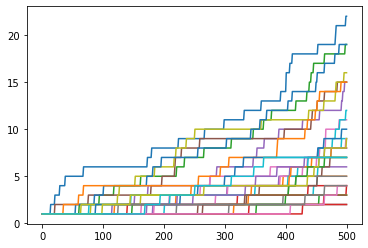

In [ ]:
for i in range(30):
  plt.plot(result_df["Prevalence"].iloc[i])

In [ ]:
from google.colab import files
files.download(f"result(salathe)_{transmissibility/recovery}.pkl")

In [ ]:
def RRM_reshuffle(network):
    '''
    This function randomly shuffles the snapshot time ordering.
    It therefore breaks the temporal activity as well as correlations between link activations
    while preserving the properties of the aggregated network.
    
    See also the paper "Infection propagator approach to compute epidemic thresholds
    on temporal networks: impact of immunity and of limited
    temporal resolution", by Eugenio Valdano, Chiara Poletto and Vittoria Colizza, 
    European Physical Journal B, 2015.
    
    '''
    res = np.copy(network) # copy network
    
    times = np.unique(res[:,0]) # get snapshot timings
    times_shuffle = np.copy(times) 
    np.random.shuffle(times_shuffle) # shuffle timings
    
    # create a 1-to-1 mapping between old and new snapshot timings
    old_to_new_time = {t: times_shuffle[i] for i,t in enumerate(times)}
    
    # replace old snapshot timings with the corresponding new ones
    for i in range(len(res)):
        res[i,0] = old_to_new_time[res[i,0]]
    
    return res
    
def RRM_anonymize(network):
    '''
    This function reshuffles the identity of the nodes of each time snapshot,
    thus preserving activity timeline and static topology of
    each snapshot. It breaks all dynamic community structures and cliques.
    
    See also the paper "Infection propagator approach to compute epidemic thresholds
    on temporal networks: impact of immunity and of limited
    temporal resolution", by Eugenio Valdano, Chiara Poletto and Vittoria Colizza, 
    European Physical Journal B, 2015.
    '''
    
    res = np.copy(network) # copy network
    times = np.unique(res[:,0]) # get snapshot timings
    
    for t in times:
        node_labels = np.unique( res[ res[:,0] == t ][:, 1:3])  # get nodes' labels
        node_labels_shuffle = np.copy(node_labels)
        np.random.shuffle(node_labels_shuffle) # shuffle node labels
 
        # create a 1-to-1 mapping between old and new node labels
        old_to_new_labels = {old_label: node_labels_shuffle[i] for i, old_label in enumerate(node_labels)}
        
        # replace old node labels with the corresponding new ones
        for i in range(len(res)):
            if res[i,0] == t:
                res[i,1] = old_to_new_labels[res[i,1]]
                res[i,2] = old_to_new_labels[res[i,2]]
    return res

In [ ]:
# Apply randomization schemes
net_reshuffle = RRM_reshuffle(net)
net_anonymize = RRM_anonymize(net)

In [ ]:
### Reshuffled network results
# study chosen seed's prevalences

# maximum average R0 in this study will be (35 * 0.0003)/ 0.01 = 1
t_max = 2000000 # maximum simulation time
transmissibility = 0.0019 # infection probability
recovery = 0.068 # recovery probability
N0 = 1 # initial seeds
np.random.seed(123)

result = []
for seed in chosen_edge_seeds:
  for i in range(100):
    prevalence = simulate_SIR(t_max, tr = transmissibility, rec = recovery, network = net_reshuffle, N0 = N0, seed= seed)
    total = sum(prevalence)
    result.append({"seed": seed, "Total" : total, "Max":max(prevalence), "Prevalence": prevalence})


In [ ]:
result_df = pd.DataFrame(result)
result_df.to_pickle("result(salathe)_reshuffle.pkl")
result_df.sort_values('Total',ascending=False)

,seed,Total,Max,Prevalence
386,687,966,11,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
608,592,788,10,"[1, 1, 1, 1, 3, 3, 3, 4, 6, 6, 6, 5, 5, 5, 5, ..."
413,353,582,13,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
685,592,496,7,"[1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, ..."
412,353,491,8,"[1, 1, 3, 3, 3, 3, 3, 5, 4, 4, 4, 3, 3, 3, 3, ..."
...,...,...,...,...
752,418,1,1,"[1, 0]"
755,418,1,1,"[1, 0]"
771,418,1,1,"[1, 0]"
288,294,1,1,"[1, 0]"


In [ ]:
result_df.groupby("seed").Total.describe().sort_values(by='mean',ascending=False)

,count,mean,std,min,25%,50%,75%,max
seed,,,,,,,,
592,100.0,59.91,107.090266,1.0,8.00,24.0,61.25,788.0
353,100.0,59.50,101.183851,1.0,9.75,26.0,59.25,582.0
294,100.0,53.45,77.192973,1.0,7.00,20.0,64.75,352.0
418,100.0,49.79,79.962655,1.0,6.00,17.0,54.50,456.0
550,100.0,48.35,61.977411,1.0,7.75,27.0,54.00,378.0
687,100.0,44.93,112.568386,1.0,4.75,11.0,28.50,966.0
566,100.0,43.69,56.912070,1.0,8.75,22.0,51.25,307.0
287,100.0,43.55,66.771792,1.0,6.00,18.5,50.75,421.0
517,100.0,41.34,57.221212,1.0,6.00,20.5,52.50,366.0


In [ ]:
### anonymize network results
# study chosen seed's prevalences

# maximum average R0 in this study will be (35 * 0.0003)/ 0.01 = 1
t_max = 2000000 # maximum simulation time
transmissibility = 0.0019 # infection probability
recovery = 0.068 # recovery probability
N0 = 1 # initial seeds
np.random.seed(123)

result = []
for seed in chosen_edge_seeds:
  for i in range(100):
    prevalence = simulate_SIR(t_max, tr = transmissibility, rec = recovery, network = net_anonymize, N0 = N0, seed= seed)
    total = sum(prevalence)
    result.append({"seed": seed, "Total" : total, "Max":max(prevalence), "Prevalence": prevalence})


In [ ]:
result_df = pd.DataFrame(result)
result_df.to_pickle("result(salathe)_anonymize.pkl")
result_df.sort_values('Total',ascending=False)

,seed,Total,Max,Prevalence
274,294,616,7,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
667,592,457,8,"[1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 5, 5, ..."
533,550,379,7,"[1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, ..."
696,592,378,9,"[1, 1, 2, 2, 2, 3, 2, 2, 3, 3, 3, 3, 2, 5, 5, ..."
42,287,365,6,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...
664,592,1,1,"[1, 0]"
665,592,1,1,"[1, 0]"
771,418,1,1,"[1, 0]"
464,353,1,1,"[1, 0]"


In [ ]:
result_df.groupby("seed").Total.describe().sort_values(by='mean',ascending=False)

,count,mean,std,min,25%,50%,75%,max
seed,,,,,,,,
550,100.0,45.81,76.156232,1.0,5.00,14.0,44.25,379.0
592,100.0,41.77,74.248267,1.0,5.75,12.5,39.00,457.0
365,100.0,36.61,66.271388,1.0,5.00,13.0,31.25,362.0
294,100.0,33.93,69.200522,1.0,5.00,10.5,35.00,616.0
287,100.0,32.27,54.602300,1.0,4.00,11.0,34.00,365.0
517,100.0,25.12,34.276735,1.0,5.00,10.0,28.00,198.0
418,100.0,24.93,45.636963,1.0,4.00,11.5,26.25,276.0
353,100.0,24.92,34.183604,1.0,6.00,11.5,27.00,210.0
566,100.0,22.00,36.165165,1.0,4.75,9.5,24.25,232.0
